<a href="https://colab.research.google.com/github/MamadouBousso/IAProjects/blob/master/Copie_de_exploring_word_vectors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Devoir 1: Explorer les vecteurs de mots (25 Points)


Avant de commencer, assurez-vous de lire le fichier README.txt dans le même répertoire que ce notebook pour obtenir des informations de configuration importantes. Beaucoup de code est fourni dans ce notebook, et nous vous encourageons vivement à le lire et à le comprendre:)



**Notes de devoir :** Veuillez vous assurer de sauvegarder le notebook au fur et à mesure.

In [18]:
import nltk
nltk.download('reuters')

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


True

In [19]:
# Toutes les importations sont définies icic

# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

In [20]:
dir()

['END_TOKEN',
 'In',
 'KeyedVectors',
 'Out',
 'PCA',
 'START_TOKEN',
 'TruncatedSVD',
 '_',
 '_11',
 '_18',
 '_8',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_dh',
 '_i',
 '_i1',
 '_i10',
 '_i11',
 '_i12',
 '_i13',
 '_i14',
 '_i15',
 '_i16',
 '_i17',
 '_i18',
 '_i19',
 '_i2',
 '_i20',
 '_i3',
 '_i4',
 '_i5',
 '_i6',
 '_i7',
 '_i8',
 '_i9',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 '_sh',
 'datapath',
 'exit',
 'get_ipython',
 'nltk',
 'np',
 'plt',
 'pprint',
 'quit',
 'random',
 'read_corpus',
 'reuters',
 'sp',
 'sys']

In [10]:
from nltk.corpus import reuters

In [11]:
dir(reuters)

['_LazyCorpusLoader__args',
 '_LazyCorpusLoader__kwargs',
 '_LazyCorpusLoader__load',
 '_LazyCorpusLoader__name',
 '_LazyCorpusLoader__reader_cls',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '__weakref__',
 '_unload',
 'subdir',
 'unicode_repr']

In [21]:
!unzip /root/nltk_data/corpora/reuters.zip -d /root/nltk_data/corpora

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: /root/nltk_data/corpora/reuters/training/2231  
  inflating: /root/nltk_data/corpora/reuters/training/2232  
  inflating: /root/nltk_data/corpora/reuters/training/2234  
  inflating: /root/nltk_data/corpora/reuters/training/2236  
  inflating: /root/nltk_data/corpora/reuters/training/2237  
  inflating: /root/nltk_data/corpora/reuters/training/2238  
  inflating: /root/nltk_data/corpora/reuters/training/2239  
  inflating: /root/nltk_data/corpora/reuters/training/2240  
  inflating: /root/nltk_data/corpora/reuters/training/2244  
  inflating: /root/nltk_data/corpora/reuters/training/2246  
  inflating: /root/nltk_data/corpora/reuters/training/2247  
  inflating: /root/nltk_data/corpora/reuters/training/2249  
  inflating: /root/nltk_data/corpora/reuters/training/225  
  inflating: /root/nltk_data/corpora/reuters/training/2251  
  inflating: /root/nltk_data/corpora/reuters/training/2252  
  inflat

## Word Vectors




Les vecteurs de mots sont souvent utilisés comme composant fondamental pour les tâches NLP en aval, par ex. réponse aux questions, génération de texte, traduction, etc., il est donc important de bien comprendre leurs forces et leurs faiblesses. Ici, vous explorerez deux types de vecteurs de mots : ceux dérivés de *matrices de cooccurrence* et ceux dérivés de *GloVe*.



## Part 1: Count-Based Word Vectors (10 points)

Idee de base:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*




De nombreuses implémentations de vecteurs de mots sont motivées par l'idée que des mots similaires, c'est-à-dire des (presque) synonymes, seront utilisés dans des contextes similaires. En conséquence, des mots similaires seront souvent prononcés ou écrits avec un sous-ensemble partagé de mots, c'est-à-dire des contextes. En examinant ces contextes, nous pouvons essayer de développer des embeddings pour nos mots. Avec cette intuition à l'esprit, de nombreuses approches "à l'ancienne" pour construire des vecteurs de mots reposaient sur le nombre de mots. Ici, nous élaborons sur l'une de ces stratégies, les *matrices de co-occurrence* (pour plus d'informations, voir [ici](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) ou [ici ](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence



Une matrice de cooccurrence compte la fréquence à laquelle les choses se produisent dans un environnement. Étant donné un mot $w_i$ apparaissant dans le document, nous considérons la *fenêtre contextuelle* entourant $w_i$. Supposons que notre taille de fenêtre fixe soit $n$, alors ce sont les $n$ mots précédents et $n$ suivants dans ce document, c'est-à-dire les mots $w_{in} \dots w_{i-1}$ et $w_{i+ 1} \points w_{i+n}$. Nous construisons une *matrice de cooccurrence* $M$, qui est une matrice symétrique mot par mot dans laquelle $M_{ij}$ est le nombre de fois que $w_j$ apparaît dans la fenêtre de $w_i$ parmi tous les documents .

**Example: Co-Occurrence avec une fenetre fixe n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |




**Remarque :** En NLP, nous ajoutons souvent des jetons `<START>` et `<END>` pour représenter le début et la fin de phrases, de paragraphes ou de documents. Dans ce cas, nous imaginons les jetons `<START>` et `<END>` encapsulant chaque document, par exemple, "`<START>` all that glitters is not gold `<END>`", et incluons ces jetons dans notre co-nombre d'occurrences.

Les lignes (ou colonnes) de cette matrice fournissent un type de vecteurs de mots (ceux basés sur la cooccurrence mot-mot), mais les vecteurs seront en général grands (linéaires en nombre de mots distincts dans un corpus). Ainsi, notre prochaine étape consiste à exécuter la *réduction de dimensionnalité*. En particulier, nous exécuterons *SVD (Singular Value Decomposition)*, qui est une sorte de *PCA (Principal Components Analysis)* généralisée pour sélectionner les $k$ composants principaux. Voici une visualisation de la réduction de dimensionnalité avec SVD. Dans cette image, notre matrice de cooccurrence est $A$ avec $n$ lignes correspondant à $n$ mots. Nous obtenons une décomposition matricielle complète, avec les valeurs singulières ordonnées dans la matrice diagonale $S$, et nos nouveaux vecteurs de mots de longueur plus courte-$k$ dans $U_k$.

![Picture of an SVD](./imgs/svd.png "SVD")



Cette représentation de cooccurrence à dimension réduite préserve les relations sémantiques entre les mots, par ex. *docteur* et *hôpital* seront plus proches que *docteur* et *chien*.

**Remarques :** Si vous vous souvenez à peine de ce qu'est une valeur propre, voici [une introduction lente et conviviale à SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf). Si vous souhaitez en savoir plus sur la PCA ou la SVD, n'hésitez pas à consulter les conférences [7](https://web.stanford.edu/class/cs168/l/l7.pdf), [8](http:/ /theory.stanford.edu/~tim/s15/l/l8.pdf), et [9](https://web.stanford.edu/class/cs168/l/l9.pdf) de CS168. Ces notes de cours fournissent une bonne presentation de haut niveau de ces algorithmes à usage général. Cependant, pour les besoins de ce cours, il vous suffit de savoir comment extraire les k dimensions des embeddings en utilisant des implémentations préprogrammées de ces algorithmes à partir des packages python numpy, scipy ou sklearn. En pratique, il est difficile d'appliquer la SVD complète à de grands corpus en raison de la mémoire nécessaire pour effectuer une PCA ou une SVD. Cependant, si vous ne voulez que les $k$ composants vectoriels supérieurs pour un $k$ relativement petits - connus sous le nom de [Truncated SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition#Truncated_SVD) - alors il existe des techniques raisonnablement évolutives pour les calculer de manière itérative.


### Plotting Co-Occurrence Word Embeddings



Ici, nous utiliserons le corpus Reuters (actualité économique et financière). Si vous n'avez pas exécuté la cellule d'importation en haut de cette page, veuillez l'exécuter maintenant (cliquez dessus et appuyez sur MAJ-RETOUR). Le corpus se compose de 10 788 documents d'actualité totalisant 1,3 million de mots. Ces documents couvrent 90 catégories et sont divisés en train et test. Pour plus de détails, veuillez consulter https://www.nltk.org/book/ch02.html. Nous proposons ci-dessous une fonction "read_corpus" qui extrait uniquement les articles de la catégorie "crude" (c'est-à-dire les articles de presse sur le pétrole, le gaz, etc.). La fonction ajoute également des jetons `<START>` et `<END>` à chacun des documents, et des mots en minuscules. Vous n'avez **pas** à effectuer un autre type de pré-traitement.

In [22]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Regardons ces documents...

In [23]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:3], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` [code] (2 points)



Écrivez une méthode pour déterminer les mots distincts (types de mots) qui apparaissent dans le corpus. Vous pouvez le faire avec des boucles `for`, mais il est plus efficace de le faire avec des compréhensions de liste Python. En particulier, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) peut être utile pour aplatir une liste de listes. Si vous n'êtes pas familier avec les compréhensions de liste Python en général, voici [plus d'informations](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

Vos `corpus_words` renvoyés doivent être triés. Vous pouvez utiliser la fonction "sorted" de python pour cela.

Vous trouverez peut-être utile d'utiliser [Python sets](https://www.w3schools.com/python/python_sets.asp) pour supprimer les mots en double.

In [30]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): sorted list of distinct words across the corpus
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    
    # ------------------
    # Write your implementation here.
    
    corpus_words = sorted(set([word for liste in corpus for word in liste]))
    num_corpus_words = len(corpus_words)
    # ------------------

    return corpus_words, num_corpus_words

In [31]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` [code] (3 points)



Écrivez une méthode qui construit une matrice de cooccurrence pour une certaine taille de fenêtre $n$ (avec une valeur par défaut de 4), en considérant les mots $n$ avant et $n$ après le mot au centre de la fenêtre. Ici, nous commençons à utiliser `numpy (np)` pour représenter des vecteurs, des matrices et des tenseurs. Si vous n'êtes pas familier avec NumPy, il y a un tutoriel NumPy dans la seconde moitié de ce cs231n [Tutoriel Python NumPy] (http://cs231n.github.io/python-numpy-tutorial/).


In [70]:
def get_neighbours_index(idx,list_words,window_size=4):
  '''
  Obtenir les index des voisins suivant  la taille de la fenêtre
  '''
  start = idx - window_size if (idx - window_size) >= 0 else  0
  end = idx + window_size if (idx + window_size) < len(list_words) else len(list_words)-1
  return list_words[start:idx]+list_words[idx+1:end+1]

In [71]:
def get_neighbours(word ,list_words,window_size=4):
  '''
  Obtenir la liste des voisins suivant le window_size
  '''
  list_neighbours = []
  list_index = [i for i,val in enumerate(list_words) if val==word]
  #print(list_index)
  for idx in list_index:
    list_neighbours.extend(get_neighbours_index(idx,list_words,window_size))
  
  return list_neighbours

In [72]:
def get_indices(list_words,word2ind):
  '''
  Permet d'obtenir la liste des indices des voisins
  '''
  list_ind = []
  for word in list_words:
    list_ind.append(word2ind[word])
  return list_ind

In [73]:
test_corpus = "{} All that glitters isn't All gold {}".format(START_TOKEN, END_TOKEN).split(" ")

get_neighbours("All" ,test_corpus,1)

['<START>', 'that', "isn't", 'gold']

In [74]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).
    
        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.
              
              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".
    
        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): 
                Co-occurence matrix of word counts. 
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = None
    word2ind = {}
    
    # ------------------
    # Write your implementation here.
    M = np.zeros((num_words,num_words))
    for word in words:
      word2ind[word]= words.index(word)
    
    for liste in corpus:
        for word in liste:
          i = word2ind[word]
          list_neighbours = get_neighbours(word ,liste,window_size)
          indices = get_indices(list_neighbours,word2ind)
          for j in indices:
            M[i,j] = 1
    


    # ------------------

    return M, word2ind

In [75]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2ind
M_test_ans = np.array( 
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2ind
assert (word2ind_ans == word2ind_test), "Your word2ind is incorrect:\nCorrect: {}\nYours: {}".format(word2ind_ans, word2ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2ind_ans.keys():
    idx1 = word2ind_ans[w1]
    for w2 in word2ind_ans.keys():
        idx2 = word2ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` [code] (1 point)



Construisez une méthode qui effectue une réduction de dimensionnalité sur la matrice pour produire des embeddings à k dimensions. Utilisez SVD pour prendre les k principaux composants et produire une nouvelle matrice de embeddings à k dimensions.

**Remarque :** Tous numpy, scipy et scikit-learn (`sklearn`) fournissent *certaines* implémentations de SVD, mais seuls scipy et sklearn fournissent une implémentation de SVD tronqué, et seul sklearn fournit un algorithme randomisé efficace pour calcul de SVD tronqué à grande échelle. Veuillez donc utiliser [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [76]:
import sklearn

In [79]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html
    
        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """    
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    M_reduced = None
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
    
        # ------------------
        # Write your implementation here.
    svd = sklearn.decomposition.TruncatedSVD(k,n_iter=7, random_state=42)
    M_reduced = svd.fit_transform(M)
    
        # ------------------

    print("Done.")
    return M_reduced

In [80]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness 
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` [code] (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](http://web.archive.org/web/20190924160434/https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

Ici, vous allez écrire une fonction pour tracer un ensemble de vecteurs 2D dans un espace 2D. Pour les graphiques, nous utiliserons Matplotlib (`plt`).

 À l'avenir, un bon moyen de faire un graphique est de regarder [la galerie Matplotlib](https://matplotlib.org/gallery/index.html), et de trouver un graphique qui ressemble un peu à ce que vous voulez et d'adapter le code qu'ils donnent.

In [83]:
def plot_embeddings(M_reduced, word2ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2ind.
        Include a label next to each point.
        
        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    fig, ax = plt.subplots(figsize=(16, 16))
    for word in words:
      idx = word2ind[word]
      plt.scatter(M_reduced[idx, 0],M_reduced[idx, 1], color='steelblue')
      plt.annotate(word, (M_reduced[idx, 0], M_reduced[idx, 1]), alpha=0.7)

    # ------------------

--------------------------------------------------------------------------------
Outputted Plot:
--------------------------------------------------------------------------------


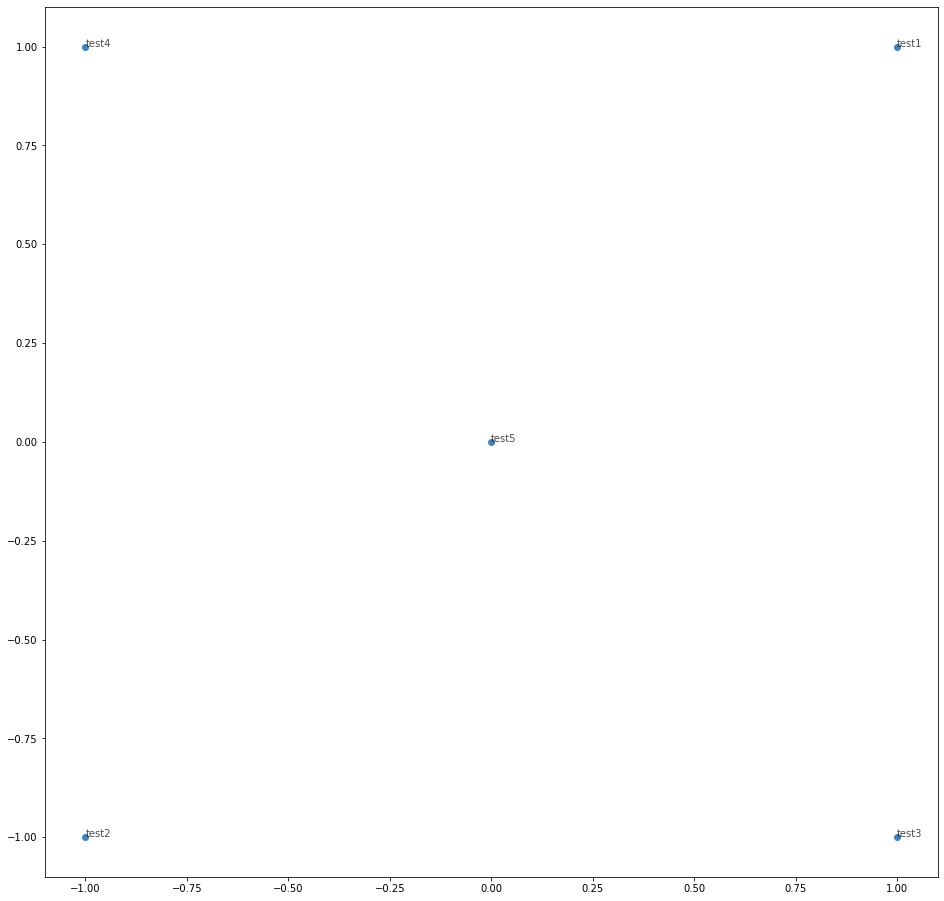

In [84]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below. 
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2ind_plot_test, words)

print ("-" * 80)

<font color=red>**Test Plot Solution**</font>
<br>
<img src="./imgs/test_plot.png" width=40% style="float: left;"> </img>


### Question 1.5: Co-Occurrence Plot Analysis [written] (3 points)



Maintenant, nous allons rassembler toutes les parties que vous avez écrites ! Nous allons calculer la matrice de cooccurrence avec une fenêtre fixe de 4 (la taille de fenêtre par défaut), sur le corpus "brut" (pétrole) de Reuters. Ensuite, nous utiliserons TruncatedSVD pour calculer les embeddings en 2 dimensions de chaque mot. TruncatedSVD renvoie U*S, nous devons donc normaliser les vecteurs renvoyés, de sorte que tous les vecteurs apparaissent autour du cercle unité (donc la proximité est la proximité directionnelle). **Remarque** : La ligne de code ci-dessous qui effectue la normalisation utilise le concept NumPy de *diffusion*. Si vous ne connaissez pas la diffusion, consultez
[Calcul sur tableaux : diffusion par Jake VanderPlas] (https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Exécutez la cellule ci-dessous pour produire le tracé. Il faudra probablement quelques secondes pour s'exécuter. Qu'est-ce qui se regroupe dans un espace d'insertion bidimensionnel ? Qu'est-ce qui ne se regroupe pas que vous pourriez penser qu'il devrait y avoir ? **Remarque :** « bpd » signifie « barils par jour » et est une abréviation couramment utilisée dans les articles sur le pétrole brut.

Running Truncated SVD over 8185 words...
Done.


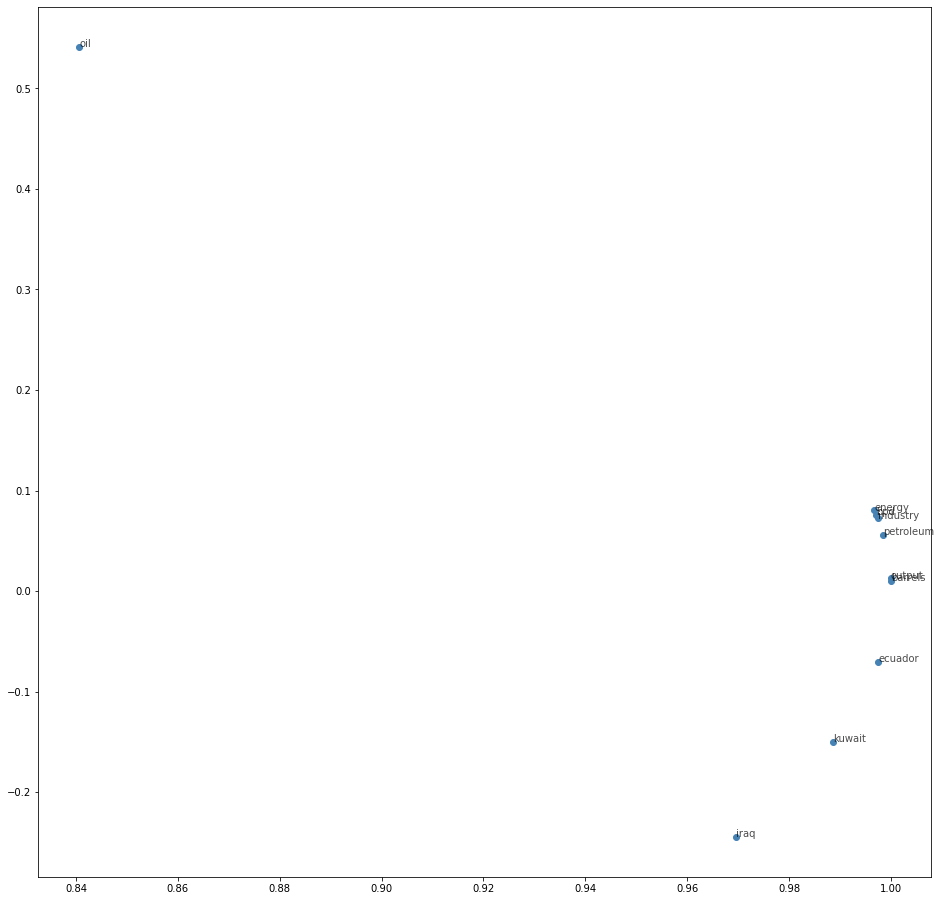

In [85]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']

plot_embeddings(M_normalized, word2ind_co_occurrence, words)

#### <font color="red">Write your answer here.</font>


## Part 2: Prediction-Based Word Vectors (15 points)

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take a couple minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

Comme discuté en classe, plus récemment, les vecteurs de mots basés sur la prédiction ont démontré de meilleures performances, tels que word2vec et GloVe (qui utilise également le comptage). Ici, nous allons explorer les embeddings produits par GloVe.  Lancez-vous un défi et essayez de lire [l'article original de GloVe] (https://nlp.stanford.edu/pubs/glove.pdf).

Exécutez ensuite les cellules suivantes pour charger les vecteurs GloVe en mémoire. 
**Remarque** : Si c'est la première fois que vous exécutez ces cellules, c'est-à-dire que vous téléchargez le modèle d'intégration, l'exécution prendra quelques minutes. Si vous avez déjà exécuté ces cellules, les réexécuter chargera le modèle sans le télécharger à nouveau, ce qui prendra environ 1 à 2 minutes.

In [86]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_from_bin.vocab.keys()))
    return wv_from_bin

In [87]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take a couple minutes
# -----------------------------------
wv_from_bin = load_embedding_model()

[==================================================] 100.0% 252.1/252.1MB downloaded
Loaded vocab size 400000


#### Note: Si vous obtenez une erreur "reset by peer" reexecuter la cellule. 

### Reducing dimensionality of Word Embeddings


Comparons directement les embeddings de GloVe à ceux de la matrice de cooccurrence. Afin d'éviter de manquer de mémoire, nous allons plutôt travailler avec un échantillon de 10 000 vecteurs GloVe.
Exécutez les cellules suivantes pour :

1. Mettez 10000 vecteurs Glove dans une matrice M
2. Exécutez `reduce_to_k_dim` (votre fonction SVD tronquée) pour réduire les vecteurs de 200 dimensions à 2 dimensions.

In [88]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.vocab.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2ind and matrix M..." % len(words))
    word2ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2ind

In [89]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.




**Remarque : Si vous rencontrez des problèmes de mémoire insuffisante sur votre ordinateur local, essayez de fermer d'autres applications pour libérer plus de mémoire sur votre appareil. Vous pouvez essayer de redémarrer votre machine afin de libérer de la mémoire supplémentaire. Ensuite, exécutez immédiatement le bloc-notes jupyter et voyez si vous pouvez charger correctement les vecteurs de mots. **

### Question 2.1: GloVe Plot Analysis [written] (3 points)


Exécutez la cellule ci-dessous pour tracer les embeddings 2D GloVe pour `['barils', 'bpd', 'ecuador', 'energy', 'industry', 'koweït', 'oil', 'output', 'petroleum', ' irak']`.

Qu'est-ce qui se regroupe dans un espace  bidimensionnel ? Qu'est-ce qui ne se regroupe pas et qui, selon vous, devrait avoir lieu ? En quoi le tracé est-il différent de celui généré plus tôt à partir de la matrice de cooccurrence ? Quelle est la cause possible de la différence ?

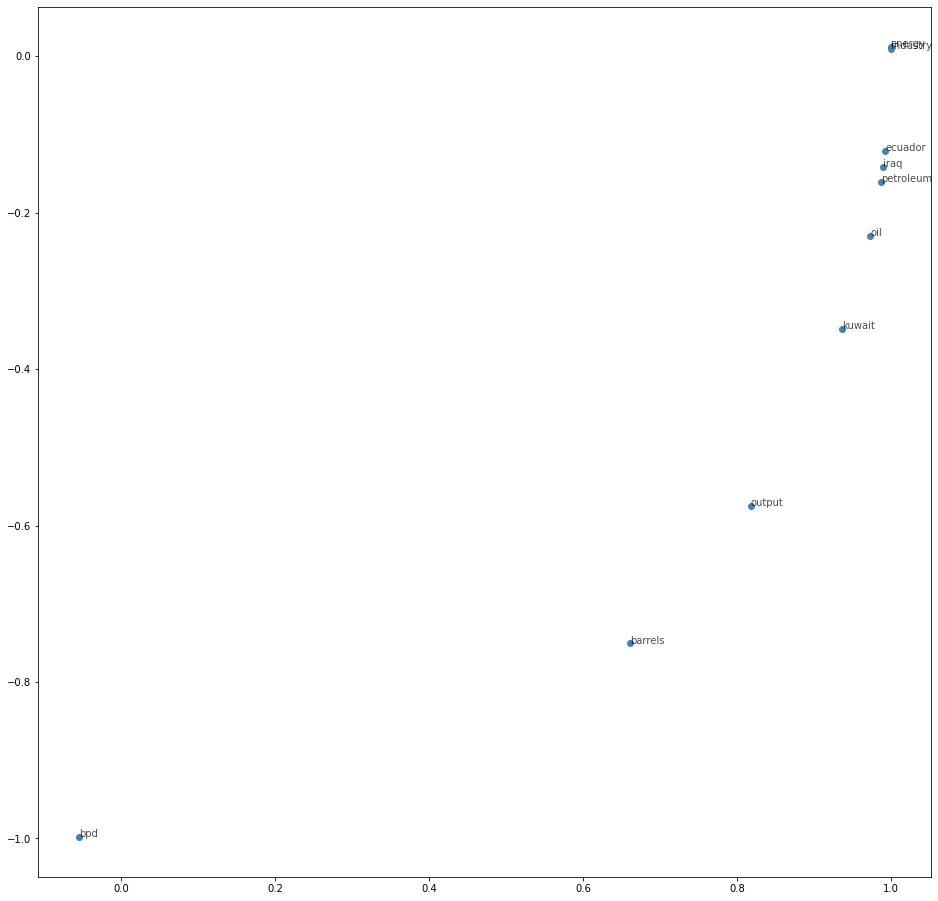

In [90]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'iraq']
plot_embeddings(M_reduced_normalized, word2ind, words)

#### <font color="red">Write your answer here.</font>

### Cosine Similarity

Maintenant que nous avons des vecteurs de mots, nous avons besoin d'un moyen de quantifier la similitude entre les mots individuels, en fonction de ces vecteurs. L'une de ces métriques est la similitude en cosinus. Nous l'utiliserons pour trouver des mots « proches » et « éloignés » les uns des autres.

Nous pouvons considérer les vecteurs à n dimensions comme des points dans un espace à n dimensions. Si nous prenons cette norme [L1](http://mathworld.wolfram.com/L1-Norm.html) et [L2](http://mathworld.wolfram.com/L2-Norm.html) Les distances aident à quantifier la quantité d'espace à parcourir pour joindre ces deux points. Une autre approche consiste à examiner l'angle entre deux vecteurs. D'après la trigonométrie, nous savons que :

<img src="./imgs/inner_product.png" width=20% style="float: center;"></img>

Au lieu de calculer l'angle réel, nous pouvons laisser la similitude en termes de $similarity = cos(\Theta)$. Formellement, la [similarité du cosinus](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ entre deux vecteurs $p$ et $q$ est définie comme :

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ où } s \in [-1, 1] $$

### Question 2.2: Words with Multiple Meanings (1.5 points) [code + written] 


Les polysèmes et les homonymes sont des mots qui ont plus d'un sens (voir cette [page wiki](https://en.wikipedia.org/wiki/Polysemy) pour en savoir plus sur la différence entre polysèmes et homonymes). Trouvez un mot avec *au moins deux sens différents* de sorte que les 10 mots les plus similaires (selon la similarité cosinusoïdale) contiennent des mots apparentés provenant des *deux* sens. 

Veuillez indiquer le mot que vous découvrez et les significations multiples qui apparaissent dans le top 10. Pourquoi pensez-vous que la plupart des mots polysémiques ou homonymes que vous avez essayés n'ont pas fonctionné (c'est-à-dire que les 10 mots les plus similaires ne contiennent qu'** un ** des sens des mots) ?

**Remarque** : Vous devez utiliser la fonction `wv_from_bin.most_similar(word)` pour obtenir les 10 premiers mots similaires. Cette fonction classe tous les autres mots du vocabulaire en fonction de leur similarité cosinusoïdale avec le mot donné. Pour obtenir de l'aide, veuillez consulter la __[documentation GenSim](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [92]:
    # ------------------
    # Write your implementation here.
wv_from_bin.most_similar('bank')

    # ------------------

[('banks', 0.7625691890716553),
 ('banking', 0.6818838119506836),
 ('central', 0.6283639669418335),
 ('financial', 0.6166563034057617),
 ('credit', 0.6049750447273254),
 ('lending', 0.5980608463287354),
 ('monetary', 0.5963002443313599),
 ('bankers', 0.5913101434707642),
 ('loans', 0.5802938938140869),
 ('investment', 0.5740202069282532)]

#### <font color="red">Write your answer here.</font>

### Question 2.3: Synonyms & Antonyms (2 points) [code + written] 


Lorsque l'on considère la similarité en cosinus, il est souvent plus pratique de penser à la distance en cosinus, qui est simplement 1 - Similarité en cosinus.

Trouvez trois mots $(w_1,w_2,w_3)$ où $w_1$ et $w_2$ sont des synonymes et $w_1$ et $w_3$ sont des antonymes, mais Distance cosinus $(w_1,w_3) <$ Distance cosinus $(w_1, w_2)$.

Par exemple, $w_1$="happy" est plus proche de $w_3$="sad" que de $w_2$="cheerful". Veuillez trouver un autre exemple qui satisfait à ce qui précède. Une fois que vous avez trouvé votre exemple, veuillez donner une explication possible de la raison pour laquelle ce résultat contre-intuitif a pu se produire.

Vous devez utiliser la fonction `wv_from_bin.distance(w1, w2)` ici afin de calculer la distance en cosinus entre deux mots. Veuillez consulter la __[documentation GenSim](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ pour obtenir de l'aide.

In [100]:
    # ------------------
    # Write your implementation here.

print(wv_from_bin.distance("angry", "cross"))
print(wv_from_bin.distance("angry", "cheerful"))
    # ------------------

0.8133127242326736
0.7339662909507751


#### <font color="red">Write your answer here.</font>

### Question 2.4: Analogies with Word Vectors [written] (1.5 points)
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies. 

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x using the `most_similar` function from the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors.most_similar)__. The function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list (while omitting the input words, which are often the most similar; see [this paper](https://www.aclweb.org/anthology/N18-2039.pdf)). The answer to the analogy will have the highest cosine similarity (largest returned numerical value).

Il a été démontré que les vecteurs de mots présentent *parfois* la capacité de résoudre des analogies.

A titre d'exemple, pour l'analogie « homme : roi :: femme : x » (lire : l'homme est au roi ce que la femme est à x), qu'est-ce que x ?

Dans la cellule ci-dessous, nous vous montrons comment utiliser des vecteurs de mots pour trouver x à l'aide de la fonction `most_similar` de la __[documentation GenSim](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models. keyedvectors.KeyedVectors.most_similar)__. La fonction trouve les mots les plus similaires aux mots de la liste « positive » et les plus différents des mots de la liste « négative » (tout en omettant les mots d'entrée, qui sont souvent les plus similaires ; voir [ce document](https ://www.aclweb.org/anthology/N18-2039.pdf)). La réponse à l'analogie aura la similarité de cosinus la plus élevée (la plus grande valeur numérique renvoyée).

In [101]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678703308105),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998854637146),
 ('elizabeth', 0.546359658241272),
 ('daughter', 0.5399125814437866),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164472460746765)]




Soit $m$, $k$, $w$ et $x$ les vecteurs de mots pour « homme », « roi », « femme » et la réponse, respectivement. En utilisant **uniquement** les vecteurs $m$, $k$, $w$ et les opérateurs arithmétiques vectoriels $+$ et $-$ dans votre réponse, quelle est l'expression dans laquelle nous maximisons la similarité cosinus avec $x$ ?

Astuce : rappelez-vous que les vecteurs de mots sont simplement des vecteurs multidimensionnels qui représentent un mot. Il peut être utile de dessiner un exemple 2D en utilisant des emplacements arbitraires de chaque vecteur. Où se situeraient « homme » et « femme » dans le plan de coordonnées par rapport à « roi » et la réponse ?

#### <font color="red">Write your answer here.</font>
$x = w + k - m $ 

### Question 2.5: Finding Analogies [code + written]  (1.5 points)


Trouvez un exemple d'analogie qui tient en fonction de ces vecteurs (c'est-à-dire que le mot voulu est classé en premier). Dans votre solution, veuillez indiquer l'analogie complète sous la forme x:y :: a:b. Si vous pensez que l'analogie est compliquée, expliquez pourquoi l'analogie tient en une ou deux phrases.

**Remarque** : Vous devrez peut-être essayer de nombreuses analogies pour en trouver une qui fonctionne !

In [108]:
    # ------------------
    # Write your implementation here.
def analogy(x, y, a):
  result = wv_from_bin.most_similar(positive=[a, y], negative=[x])
  return result[0][0]

analogy('man','king','woman')

    # ------------------

'queen'

#### <font color="red">Write your answer here.</font>

### Question 2.6: Incorrect Analogy [code + written] (1.5 points)


Trouvez un exemple d'analogie qui ne tient *pas* selon ces vecteurs. Dans votre solution, indiquez l'analogie voulue sous la forme x:y :: a:b, et indiquez la valeur (incorrecte) de b en fonction des vecteurs de mots.

In [109]:
    # ------------------
    # Write your implementation here.

analogy('boy','cat','girl')
    # ------------------

'dog'

#### <font color="red">Write your answer here.</font>

### Question 2.7: Guided Analysis of Bias in Word Vectors [written] (1 point)



Il est important d'être conscient des préjugés (sexe, race, orientation sexuelle, etc.) implicites dans nos imbrications de mots. Les biais peuvent être dangereux car ils peuvent renforcer les stéréotypes à travers des applications qui utilisent ces modèles.

Exécutez la cellule ci-dessous pour examiner (a) quels termes sont les plus similaires à « femme » et « travailleur » et les plus dissemblables à « homme », et (b) quels termes sont les plus similaires à « homme » et « travailleur » et les plus différent de "femme". Soulignez la différence entre la liste des mots associés aux femmes et la liste des mots associés aux hommes, et expliquez en quoi cela reflète les préjugés sexistes.

In [110]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068919897079468),
 ('nurse', 0.5837947726249695),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321309566497803),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741914749146),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.6113258004188538),
 ('employee', 0.5983108282089233),
 ('working', 0.5615328550338745),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.5368517637252808),
 ('job', 0.5278826951980591),
 ('work', 0.5223963260650635),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.505452036857605),
 ('factory', 0.4940453767776489)]


#### <font color="red">Write your answer here.</font>

### Question 2.8: Independent Analysis of Bias in Word Vectors [code + written]  (1 point)


Utilisez la fonction `most_similar` pour trouver un autre cas où un certain biais est présenté par les vecteurs. Veuillez expliquer brièvement l'exemple de biais que vous découvrez.

In [112]:
    # ------------------
    # Write your implementation here.

pprint.pprint(wv_from_bin.most_similar(positive=['black', 'work'], negative=['white']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['white', 'work'], negative=['black']))
    # ------------------

[('works', 0.6942852735519409),
 ('working', 0.6901699900627136),
 ('well', 0.6618597507476807),
 ('many', 0.6213644742965698),
 ('done', 0.6055552363395691),
 ('so', 0.6047264933586121),
 ('others', 0.5898340344429016),
 ('writing', 0.5866991281509399),
 ('worked', 0.5866532921791077),
 ('way', 0.5826850533485413)]

[('working', 0.7428555488586426),
 ('worked', 0.6880596280097961),
 ('done', 0.6846398711204529),
 ('works', 0.6522983312606812),
 ('job', 0.6191713213920593),
 ('administration', 0.6135555505752563),
 ('doing', 0.6118285655975342),
 ('for', 0.5964169502258301),
 ('well', 0.5938922166824341),
 ('but', 0.5933554172515869)]


#### <font color="red">Write your answer here.</font>